# # データ構造化事例　＃4
## 放射光XRD高温高圧プレス装置　SPring-8_BL14B1-XRDPress



**対応機種** ：　 XRD高温高圧プレス装置  
**rawデータ**：　* .npdファイル　（複数ファイル可）  
**スクリプトの内容**：  
SPring-8のQST専用ビームライン（BL14B1）に設置されているXRD高温高圧プレス装置のデータについて，特定の条件に基づいた連続する測定ファイルからスタック図を作成する．

![image](https://user-images.githubusercontent.com/38028745/133562394-ff25452d-9d4f-4af3-903e-fdfc3910da10.png)

## サンプルデータを読み込みましょう

In [1]:
!git clone https://github.com/ARIM-Training/Training_Program_4.git
%cd Training_Program_4

Cloning into 'Training_Program_4'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 8), reused 29 (delta 1), pack-reused 0
Unpacking objects: 100% (60/60), done.
/content/Training_Program_4


<hr>

## 1. ライブラリーを読み込みましょう
最初にコードを走らせるのに必要なライブラリーを読み込みます．ライブラリとしては以下を使っています．
 * 標準ライブラリー: ``glob``, ``os``, ``csv``
 * 数値処理用: ``pandas``
 * 可視化用: ``matplotlib``  

In [2]:
# 必要なモジュール
# ファイル操作のモジュール
import glob
import os
import csv

# 数値処理用
import pandas as pd

# 可視化
from matplotlib import pyplot as plt

また，出力結果を「output」フォルダーに保存するため，そのフォルダーの作成をします．

In [3]:
output_folder = 'output'
os.makedirs(output_folder,exist_ok = True)

## 2. ファイルの拡張子を調べます
データ構造化するファイルを特定する``read_files``関数はTraining_Program_1と同じです．今回はマルチファイルとなっているため，``read_files``関数の効力が発揮されます．　

取り込むファイルを「data」に配置します．SPring-8のBL14B1のファイルである.npdファイルを配置してみてください．

In [4]:
def read_files(extension):
    """
    概要: 特定の拡張子のついたファイルをすべて読み込む
    @param extension: 読み込む拡張子
    @return ファイル名，ファイル数，拡張子を抜いたファイル名（タイトルや出力で使うファイル名）
    """

    #入力データのフォルダーを"data"とする
    path = 'data/*' + extension

    input_files = glob.glob(path)

    # 読み込みファイル数の取得
    number_of_files = len(input_files)

    # 拡張子を抜いたファイル名（出力用）
    output_name = [os.path.splitext(os.path.basename(p))[0] for p in input_files]

    return input_files, number_of_files, output_name

SPring-8のXRDの生ファイルである``.npd``を含むファイルをdefault_extensionで指定してみましょう．

In [5]:
default_extension = 'npd'
read_files(default_extension)

(['data/decomp_0007.npd',
  'data/decomp_0008.npd',
  'data/decomp_0010.npd',
  'data/decomp_0001.npd',
  'data/decomp_0006.npd',
  'data/decomp_0003.npd',
  'data/decomp_0009.npd',
  'data/decomp_0005.npd',
  'data/decomp_0004.npd',
  'data/decomp_0002.npd'],
 10,
 ['decomp_0007',
  'decomp_0008',
  'decomp_0010',
  'decomp_0001',
  'decomp_0006',
  'decomp_0003',
  'decomp_0009',
  'decomp_0005',
  'decomp_0004',
  'decomp_0002'])

上記のようにリスト配列の結果が戻ります．  
１つ目は「data」フォルダーにある.npdのファイル名（相対パス形式），２つ目はファイル数，３つ目は拡張子（.npd）を省いたファイル名です．  
３番目はグラフのタイトルや出力ファイル名で使うために準備します．

# 3. 特定の文字（単語）が何行目に出現するか
この関数もTraining_Program_1で使用しましたので詳細は割愛します．**特定の単語が現れる「行数」を判定**する関数です．

In [6]:
def get_line_number(filename,word):
    """
    概要: 特定の文字（単語）が何行目に出現するか
    @param filename: ファイル名
    @param wotd: 検索したい単語
    @return 行番号
    """
    with open(filename,  newline='') as f:
        reader = csv.reader(f)
        text = [row for row in reader]
    
    for i in range(len(text)):
        if word in text[i]:
            match_line = i
        
    return match_line

ここではdataフォルタにある「decomp_0001.npd」について”Counting sec”という文字（列）が含まれる行数を調べてみることにしましょう．  

単語判定ではword = 'Counting sec'として変数としておくと，関数には読み込みやすくなります．

In [7]:
filename = "data/decomp_0001.npd"
word = 'Counting sec'
get_line_number(filename,word)

28

上記のように”28”という数字が現れました．これは'Counting sec'という文字列（単語）が28行目にあることを示しています．（注意：pythonは0行からカウントが始まるため，1行目カウントであれば29行目となります）  

この”Counting sec”はSPring-8の.npdファイルをみると，数値部が始まる直前の単語であることがわかります．この行でヘッダー部と数値部とを切り離すことができます．

## 4. 数値化ファイル作成のための前処理
29個のヘッダーがあると，Excelでも読み込むにも使いにくい形態です．測定の設定が記録されていることでは親切ではあっても，データ処理にとっては必ずしも親切とはいえません．ヘッダーを削除した数値データのみのcsvファイルを作成しておくと使いやすくなります．  

そのための前処理として，ヘッダー部と数値部とを切り離し，数値部のみを取り出す処理を``pandas``の``read_csv``関数で行います．  

``read_csv``関数で特定の行から読み込むオプションは``header``を使います．ここでは``heaedr``は``get_line_number``関数で取得した数字を入れます．

In [8]:
def data_extract(file):
    """
    概要: 数値部の抽出
    @param file: npdファイル
    @return dataframe（ch,回折角，強度）
    """

    index_word = 'Counting sec'
    start_line = get_line_number(file,index_word)

    df = pd.read_csv(file,
                 sep=',',
                 header = start_line,
                 skip_blank_lines= False,
                 names=('ch', '2theta', 'intensity'))
    
    return df

では，decomp_0001.npdを直接指定してみましょう．dataframe形式で数値部が表示されます．

In [9]:
data = data_extract("data/decomp_0001.npd")
data

,ch,2theta,intensity
0,1,0.0543,0
1,2,0.0973,0
2,3,0.1403,0
3,4,0.1833,0
4,5,0.2263,0
...,...,...,...
4091,4092,175.9755,0
4092,4093,176.0185,0
4093,4094,176.0615,3
4094,4095,176.1045,2


## 5. 数値化csvファイルの保存
上記のdataとして出力したdataframeをcsv化します．ファイルの保存は``pandas``の``to_csv``関数を使います．ここでは，"output"というフォルダに"[ファイル名]_extract.csv"というファイル名で保存します．

その時，``index =false``とすることで行番号（インデックス番号）の出力を不要としています．

In [ ]:
data.to_csv('output' + '/' + 'decomp_0001_extract.csv',index = False)

## 6. 可視化図の作成と保存
XRDの回折図のような規定パターンのグラフはユーザー関数化しておくと便利です．ここでは``make_figure``関数として作ります．第一引数にはdataframeの数値データ，第二引数は図の中で表示するタイトル名や出力ファイル名を"file"として指定します．

グラフのレイアウトの指定方法は``matplotlib``によるものです．

In [10]:
# XRDの作図
def make_figure(df, file):
    
    print ('Making plot in progress')

    # 図の設定    
    hfont = {'fontname': 'Arial'}
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    
    # 可視化パラメータ
    X = df['2theta']
    Y = df['intensity']   
                
    # 可視化図
    ax.plot(X, Y,linewidth = 1.0, color ='black')
 
    # 軸ラベル設定
    ax.set_xlabel("2theta [degree]",**hfont, 
                  fontsize = 20, 
                  labelpad= 10,
                  fontweight='bold')
    
    ax.set_ylabel("Intensity [a.u.]",**hfont, 
                  fontsize = 20, 
                  labelpad= 10,
                  fontweight='bold')

    # 軸目盛の設定
    ax.minorticks_on()
    
    ax.tick_params(axis = 'both', 
                   which = 'both',
                   direction = "in", 
                   length = 6, 
                   labelsize=14)
    
    # グラフタイトルの設定
    ax.set_title(file, **hfont, fontsize = 16)
    
    # 出力

    plt.savefig('output' + '/' + file + '.png', dpi=300)
    plt.show()
    plt.close()

## 7. templateからのメタデータの取得

templateには多くのメタデータが含まれています．その中から使用したX線のエネルギーの最大・最小値やスタック間距離など論文などに記載が必要なメタデータのみを抽出してリスト化すると，XRDのデータ管理でも役に立ち，また後でスタック図を描くのに必須のデータです．ここでは，その作業のはじめとして，必要なメタデータをpythonの中ではdictionaly構造でkeyとして保持させます．

In [11]:
def get_metadata(extension):
    """
    概要: template（登録GUI）から入力項目をkey-valueに割り付ける
    @param extenaion: templateの拡張子
    @return key-value形式の辞書
    """
    
    #入力データのフォルダーを"data"とする
    
    path = 'data/*' + extension
    
    template_file = glob.glob(path)
 
    _dict = dict()

    with open(template_file[0], mode='r', encoding='utf-8') as f:
        line = f.readline()
        while line:
 
            d = line.rstrip(os.linesep)
            
            str = d.strip().split(',')
            key = str[0].strip()
            value = ''
            
            if len(str) > 1:
                value = str[1].strip()
                
            _dict[key] = value
                            
            line = f.readline()
                      
    return _dict

では，dataフォルダの中のcsvデータを直接指定してみましょう．Pythonの辞書型でデータが表示されます．

imput_csv = get_metadata(".csv")<br>
imput_csv<br>
などと代入すると，下でスタック図を描いた後ならcsvの中身を出力できます．

[演習]
一番下まで実行してスタック図まで出力してから，下のセルに<br>
``imput_csv = get_metadata(".csv")``<br>
``imput_csv``<br>
と入力して，CSVファイルの中を見てみましょう．

In [12]:
imput_csv = get_metadata(".csv")
imput_csv

{'': '',
 'X軸最大値（必須）': '100',
 'X軸最小値（必須）': '45',
 '[Data]': '',
 '[EOF]': '',
 '[Experiment]': '',
 '[File]': '',
 '[Graph]': '',
 '[Instrument]': '',
 '[Sample]': '',
 '[User]': '',
 '[Ver]': '',
 'decomp_0001': '',
 'decomp_0002': '100 min',
 'decomp_0004': '200 min',
 'decomp_0006': '300 min',
 'decomp_0009': '400 min',
 'decomp_0010': '',
 'スタック間距離（必須）': '500',
 'テンプレートVer': '1.0.0',
 'データセット責任者': '',
 'データ名\u3000 （必須）': '',
 'ファイル名': 'ラベル名',
 'マテリアル先端インフラ事業\u3000データ登録用記入シート（事業関係者向け）': 'Unnamed: 1',
 'ユーザー名（必須）': '',
 '利用課題名（必須）': '',
 '化学式': '',
 '固有情報': '',
 '圧力マーカー': 'ー選択ー',
 '圧力校正式': '',
 '圧力計測方法': 'ー選択ー',
 '実験 ID': '',
 '実験の説明': '',
 '温度校正式': '',
 '温度計測法': 'ー選択ー',
 '熱電対タイプ': 'ー選択ー',
 '装置 ID《固定》': '',
 '装置メーカー《固定》': 'SPring-8',
 '装置モデル《固定》': 'BL14B1',
 '装置名《固定》': 'XRD高温高圧プレス装置',
 '試料の説明': '',
 '試料名    \u3000 （必須）': '',
 '課題番号    （必須）': '',
 '高圧実験Run No': ''}

## 8. Figureクラスの定義
今回は出力データのスタック図を描くため，このようなクラスを作ってその中で処理を行いました．クラスのインスタンス変数(フィールド)はテンプレートから与えられたデータ，それからスタック図描画用のXの最大値と最小値，後になって描くことになるスタック図で使うスタック間距離です．　　

スタック図ではそれぞれのグラフを見るのに邪魔にならない分だけ上にずらして描くため，回折されたX線の強度にさらにスタック間距離の分だけ足します．  

Figureクラスには，それらのデータをまとめてスタック図を描画するmake_stack_plotを備えています．

In [13]:
class Figure():
    
    def __init__(self, template, 
                 x_min = 20, x_max = 100, distance_of_count = 100 ):
        
        self.x_min = x_min
        self.x_max = x_max
        self.distance_of_count = distance_of_count
        self.template = template
        
        print ('Making stack plot in progress')
               
    # stack図    
    def make_stack_plot(self, files, fname):
      
        # 図の初期設定
        hfont = {'fontname': 'Arial'}
        fig, ax = plt.subplots(1,1, figsize=(12,16))
    
        #　スタック図
        stack_files = files
        number_of_stacks = len(files)
       
        for i in range(number_of_stacks):
        
            data = data_extract(stack_files[i])
            
            x = data['2theta']
            y = data['intensity']
            split_distance = i * self.distance_of_count
        
            ax.plot(x, y + split_distance, 
                    linewidth = 1.0, 
                    color ='black')  
      
            # ファイル名に一致したラベルがあったときの判定およびラベル表示
            try:
                if self.template[fname[i]]:
            
                    label = str(self.template[fname[i]])
                    
                    ax.text(self.x_max + 1, split_distance, 
                            label, 
                            **hfont, 
                            fontsize = 20)
            except:
                pass
    
        # 軸ラベルの設定
        ax.set_xlabel("Energy [keV]",**hfont, 
                  fontsize = 32,
                  labelpad= 10,
                  fontweight='bold')
    
        ax.set_ylabel("Intensity [a.u.]",**hfont, 
                  fontsize = 32, 
                  labelpad= 10,
                  fontweight='bold')
 
        # 軸の設定
        ax.set_xlim(self.x_min , self.x_max)
        
        #　軸目盛り設定
        ax.minorticks_on()

        ax.tick_params(axis = 'x',
                       direction = "in", 
                       which = "both", 
                       length = 8, 
                       labelsize=20)
        
        ax.set_yticks([])
        
        # グリッドの設定
        ax.grid(which = "major", axis = "x", 
            color = "black", 
            alpha = 0.8,
            linestyle = "--", 
            linewidth = 0.3)
        
        # 出力      
        plt.savefig('output' + '/' + 'stack_plot' + '.png', dpi=300)
        plt.show()
        plt.close()

## 9. 一本化する
上記の一連の処理を一本化することをします．下記のように一本化したコードを``main``関数として定義しておきます．処理の順番を並べるだけです．
また，上記ではファイルが一つだけを想定していました．下記の``main``では複数の.npdファイルがある場合にでも実行できるよう``for``ループにしています．

計測では複数ファイルを一括して処理する場合がほとんどですので，このような一連の処理は``for``ループ化しておくと作業効率化に効いてきます．

In [14]:
# 実行処理
def main():
        
    # 初期設定
    default_extension = '.npd'
    excel_extension ='.xlsx'
    output_folder = 'output'
    os.makedirs(output_folder,exist_ok = True)
    
    # ファイルの読み込み
    [files, f_num, fname] = read_files(default_extension)
    
    # テンプレートの読み込み
    [excel_files, excel_num, excel_fname] = read_files(excel_extension)

    print(excel_files)
    
    # テンプレートをCSV形式で仮出力
    data = pd.read_excel(excel_files[0], 'Sheet-1', index_col = None)
    data.to_csv('data/csv_for_input.csv', encoding='utf-8',index = False)
    
    # データ抽出（複数ファイルでも対応が可能）
    for i in range(f_num):

        # 数値データ部の抽出
        data = data_extract(files[i])
        
        # 数値データのcsv出力および可視化図の出力
        data.to_csv(output_folder + '/' + fname[i] + '_extract.csv',index = False)
        make_figure(data, fname[i])
    
    # stack plotの作図
    template = get_metadata('.csv')
    
    # 設定値
    fig = Figure(template)
    
    fig.x_min = int(template['X軸最小値（必須）'])
    fig.x_max = int(template['X軸最大値（必須）'])
    fig.distance_of_count = int(template['スタック間距離（必須）'])
    
    fig.make_stack_plot(files,fname)

その``main``関数を下記のようにして走らせてみましょう．一連の処理が一貫で行われます．

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


['data/【様式1】XRD高温高圧プレス_Bl14B1_スタック図用.xlsx']
Making plot in progress


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


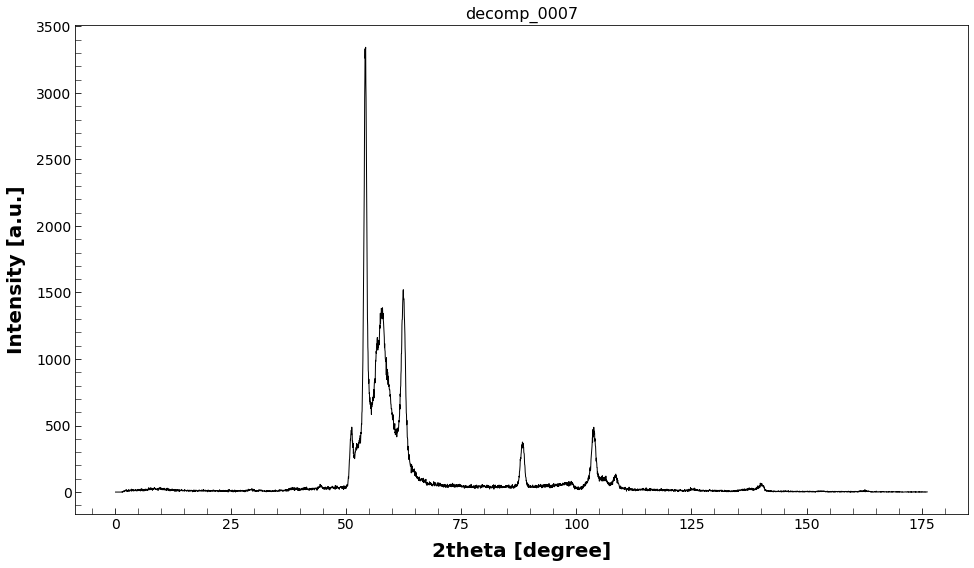

Making plot in progress


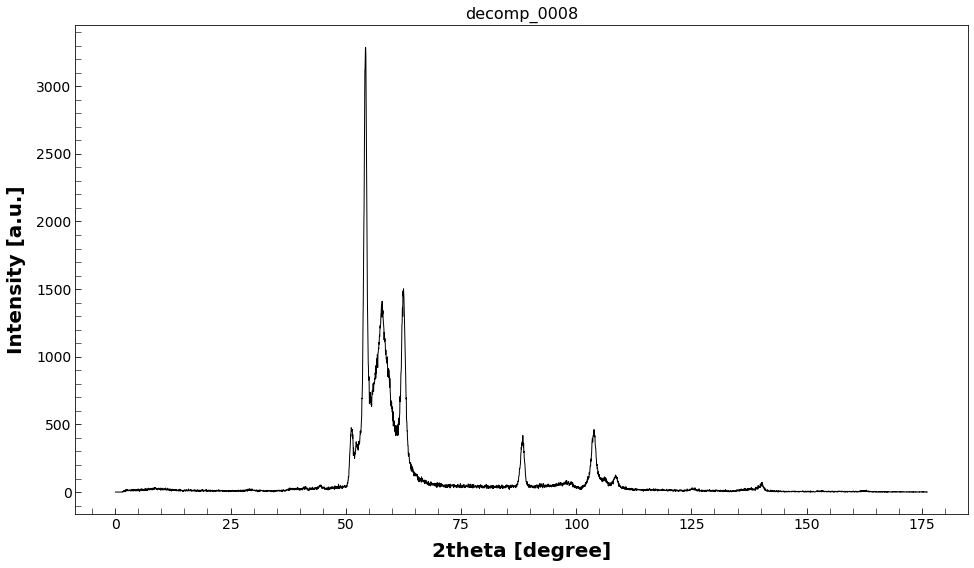

Making plot in progress


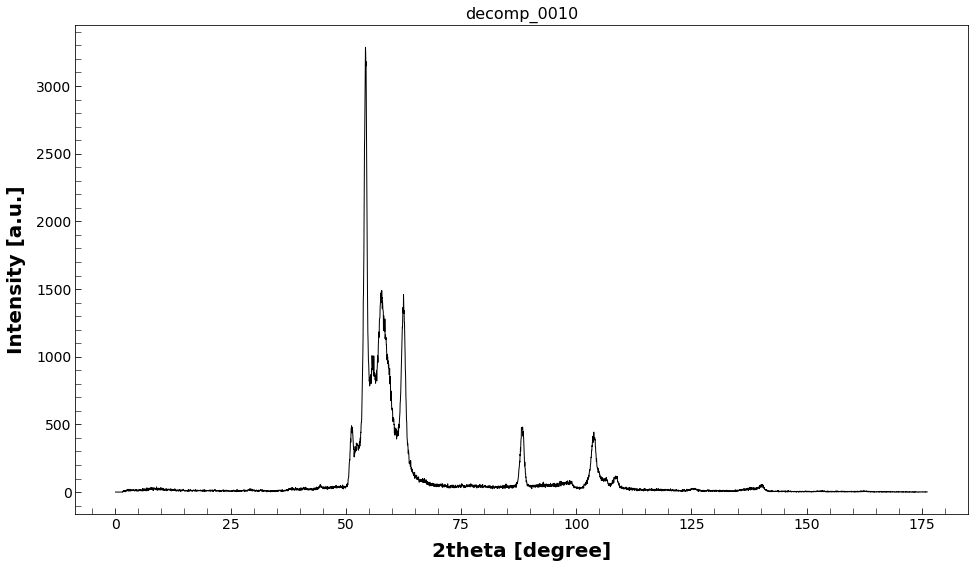

Making plot in progress


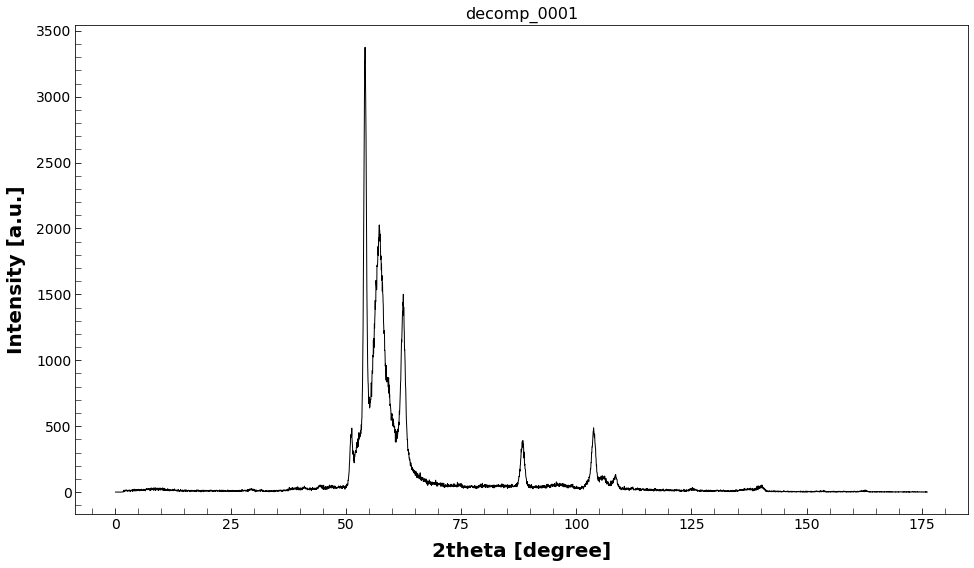

Making plot in progress


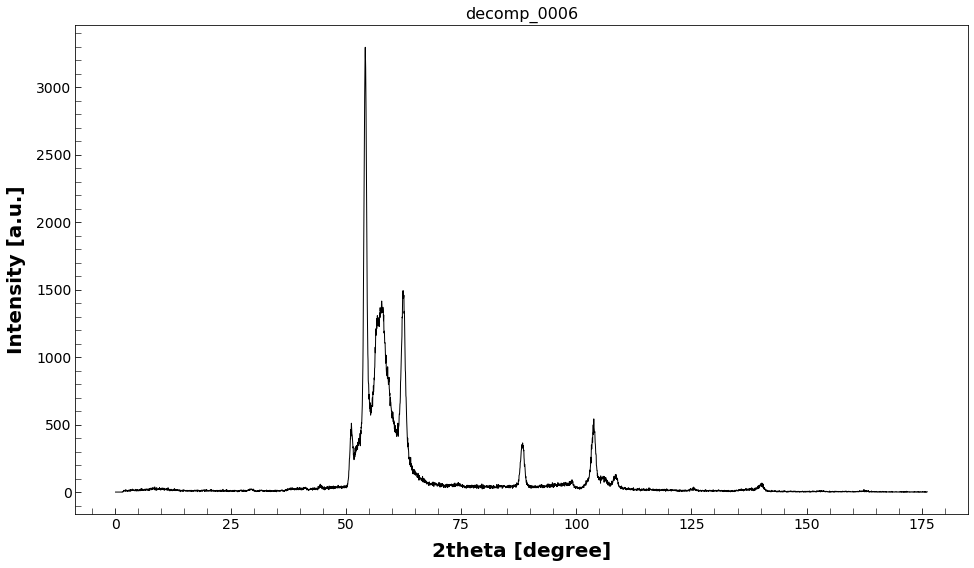

Making plot in progress


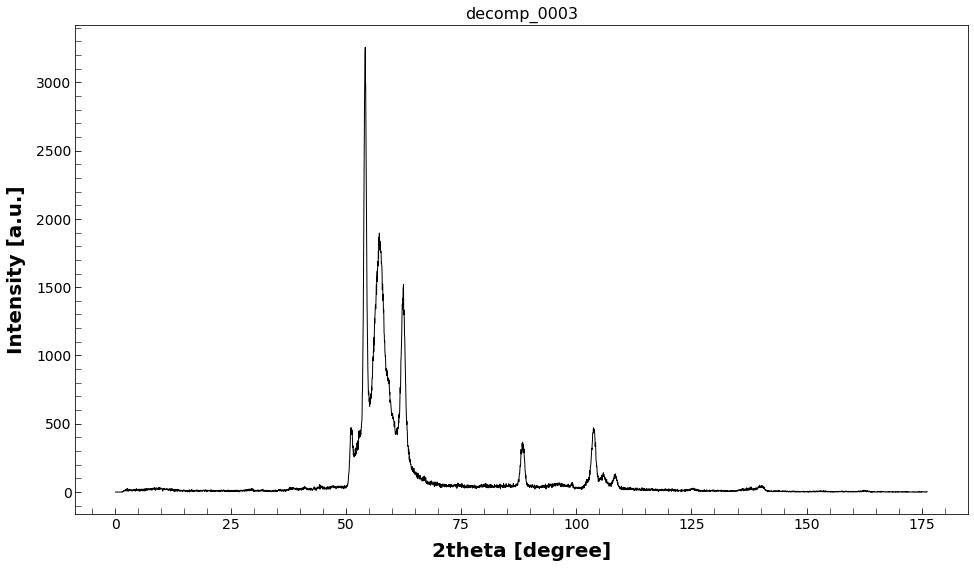

Making plot in progress


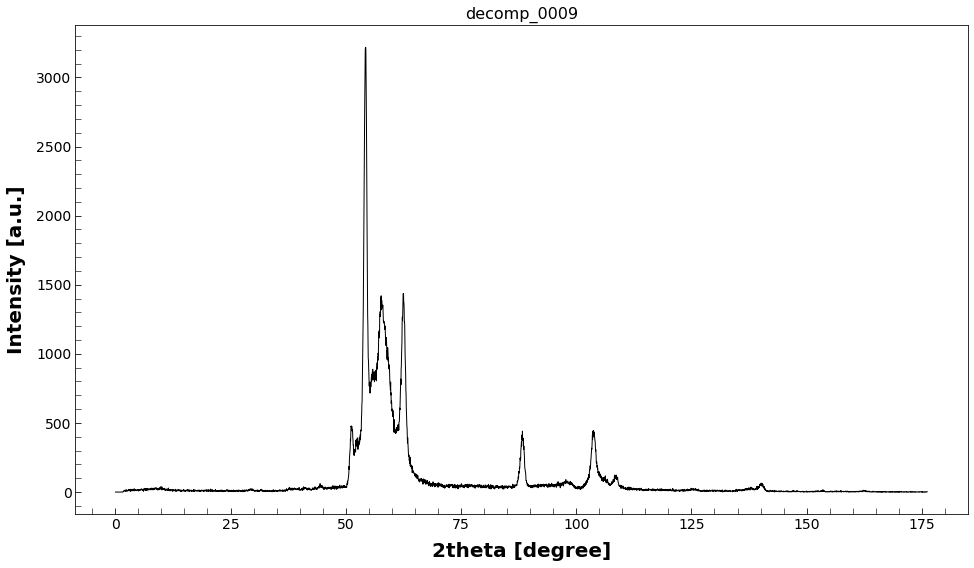

Making plot in progress


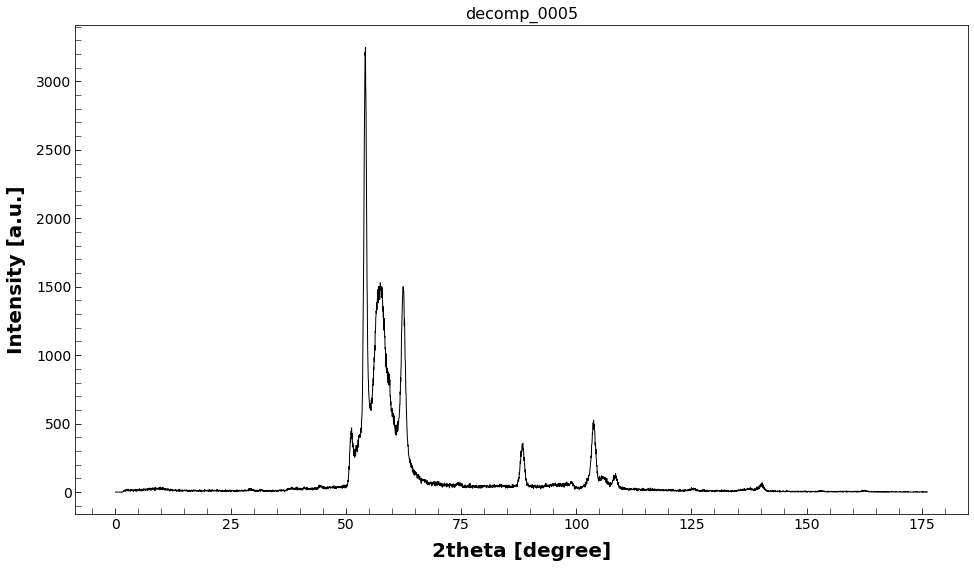

Making plot in progress


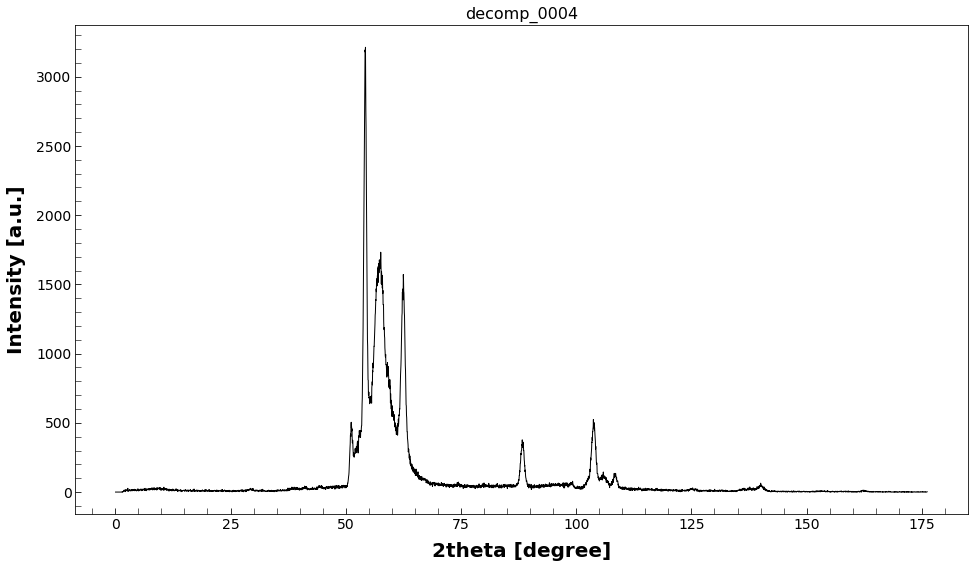

Making plot in progress


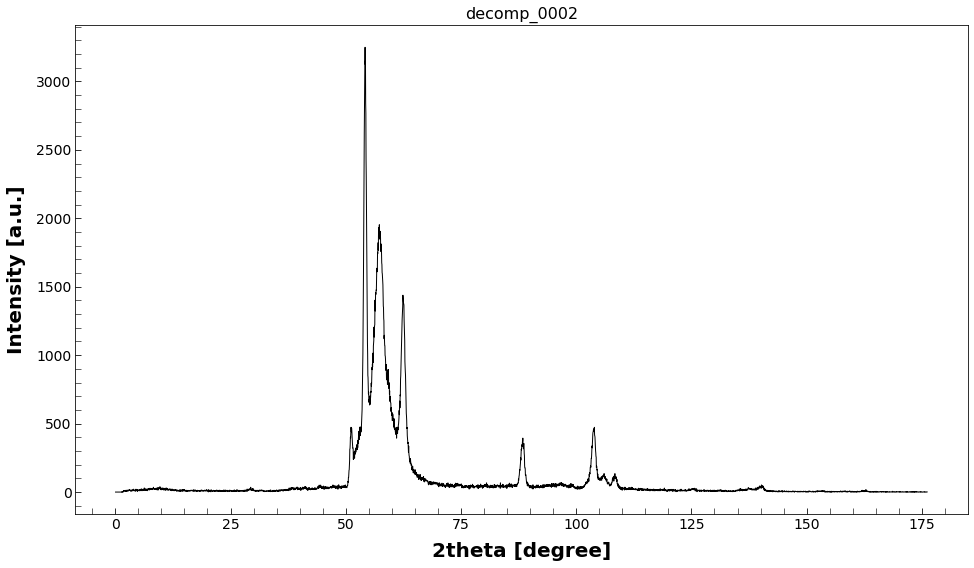

Making stack plot in progress


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


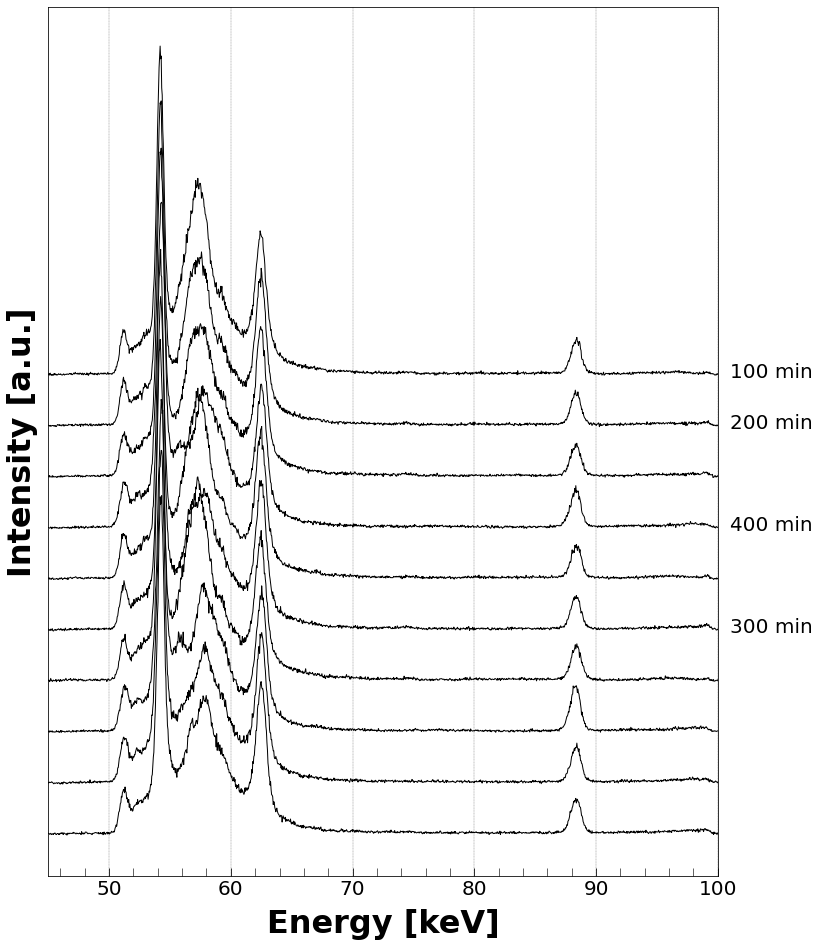

In [15]:
main()

では出力されたCSVを取り出して見てみましょう．PCをお使いの方々はoutputというフォルダーを見れば，グラフとCSVが出力されています．Google Colaboratoryをお使いの方々は，まず下のコマンドコードを実行してください．

In [16]:
!pwd
!ls

/content/Training_Program_4
data  output  README.md  requirements.txt  Training_4.ipynb


現在プログラムを実行しているフォルダーがTraining_Program_4というところで，そこにdataフォルダーやoutputフォルダー，READMEやこのプログラムの書かれたノートブックのファイルであるTraining_4.ipynbもあります．では、次のコマンドコードでoutputフォルダーに移動してみましょう．

In [17]:
%cd output/
!ls

/content/Training_Program_4/output
decomp_0001_extract.csv  decomp_0004.png	  decomp_0008_extract.csv
decomp_0001.png		 decomp_0005_extract.csv  decomp_0008.png
decomp_0002_extract.csv  decomp_0005.png	  decomp_0009_extract.csv
decomp_0002.png		 decomp_0006_extract.csv  decomp_0009.png
decomp_0003_extract.csv  decomp_0006.png	  decomp_0010_extract.csv
decomp_0003.png		 decomp_0007_extract.csv  decomp_0010.png
decomp_0004_extract.csv  decomp_0007.png	  stack_plot.png


抽出されたデータの入ったCSVファイルと，グラフの描かれた画像ファイルが複数が出てきました．これを以下のプログラムコードを実行して取り出して見ましょう．

In [18]:
from google.colab import files

files.download("decomp_0001_extract.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSVファイルが無事にダウンロード出来ましたでしょうか．画像ファイルも、同様にダウンロードできます。

In [19]:
files.download("stack_plot.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

画像ファイルが無事にダウンロード出来ましたでしょうか．<br>
<br>
ところで，ここにはあまりにも多くのファイルがありますので，全てダウンロードするのは大変です．<br>
まとめてダウンロードする方法もご紹介しましょう．<br>

まずはもう1度，このフォルダの中にあるファイルを調べます．

In [29]:
outfilename = ""
outfilename=glob.glob(os.getcwd() + '/*.*')
print(outfilename)

['/content/Training_Program_4/output/decomp_0008.png', '/content/Training_Program_4/output/decomp_0008_extract.csv', '/content/Training_Program_4/output/decomp_0005.png', '/content/Training_Program_4/output/decomp_0007_extract.csv', '/content/Training_Program_4/output/decomp_0001_extract.csv', '/content/Training_Program_4/output/decomp_0002.png', '/content/Training_Program_4/output/decomp_0010.png', '/content/Training_Program_4/output/decomp_0002_extract.csv', '/content/Training_Program_4/output/decomp_0003.png', '/content/Training_Program_4/output/decomp_0007.png', '/content/Training_Program_4/output/stack_plot.png', '/content/Training_Program_4/output/decomp_0003_extract.csv', '/content/Training_Program_4/output/decomp_0004_extract.csv', '/content/Training_Program_4/output/decomp_0001.png', '/content/Training_Program_4/output/decomp_0006_extract.csv', '/content/Training_Program_4/output/decomp_0009.png', '/content/Training_Program_4/output/decomp_0010_extract.csv', '/content/Training

今回はPythonのglob標準ライブラリを使ってファイル名を取得，そしてそれを配列化しました．次にここに外に出力するためのフォルダを作ります．

In [30]:
os.mkdir("zipout")
!ls

decomp_0001_extract.csv  decomp_0005_extract.csv  decomp_0009_extract.csv
decomp_0001.png		 decomp_0005.png	  decomp_0009.png
decomp_0002_extract.csv  decomp_0006_extract.csv  decomp_0010_extract.csv
decomp_0002.png		 decomp_0006.png	  decomp_0010.png
decomp_0003_extract.csv  decomp_0007_extract.csv  stack_plot.png
decomp_0003.png		 decomp_0007.png	  zipout
decomp_0004_extract.csv  decomp_0008_extract.csv
decomp_0004.png		 decomp_0008.png


zipoutというフォルダが出来ました．この中こ，全てのファイルをコピーしましょう．

In [32]:
import shutil
for fn in outfilename:
    shutil.copy2(fn,"zipout")

では最後に，これをshutil標準モジュールのmake_archive機能でzipファイルにまとめてみましょう．

In [33]:
shutil.make_archive("zipped_out","zip","zipout")

'/content/Training_Program_4/output/zipped_out.zip'

そしてダウンロードします．

In [34]:
files.download("zipped_out.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

皆様のお手元に，zipファイルがダウンロードできましたでしょうか．開いて中のファイルもご確認ください．

## おわりに
このXRDはスタック図を出力する発展型のデータ構造化の事例となります．基本的なポイントとなるのは次の処理項目です．

* データ構造化したいファイルを指定して読み込む
* 必要な数値部を抽出し保存する
* 数値部から可視化図を作成して保存する
* 数値部を加工するためのクラスを持つ
* クラスから各グラフのデータをメンバ変数とするオブジェクトを作り，それらを用いてスタック図を作成して保存する

あとは，お好みに応じて``make_figure``関数や``make_stack_plot``メソッドの設定を触りながらオリジナルのデザインを進めてゆくことで調整します．ここは``matplotlib``の勉強のたたき台にもなるかと思います．